# Thoracic Disease Detection Using CNNs and Weighted Binary Cross Entropy Loss Based on Chest X-Ray Images

Medical Datasets are often imbalanced, where the number of samples in the disease class is much less than the number of samples in the normal class. This imbalance in the dataset can lead to a model that has poor predictive performance, specifically for the minority class, but can appear to be accurate.

This is extremely dangerous in the medical field, where a model that appears to be accurate but is not, can lead to misdiagnosis and death. We will discuss this in more detail later in the notebook.

The dataset we will be using is the full NIH Chest X-ray dataset, which contains 112,120 X-ray images, where each image is labeled with up to 14 different diseases. The labels were created using Natural Language Processing (NLP) to mine the associated radiological reports. The labels are expected to >90% accurate. [Link to paper](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community) [Link to dataset](https://www.kaggle.com/datasets/nih-chest-xrays/data/data)

The notebook uses the whole dataset, which is about 45GB in size. We also used Data Augmentation for the underrepresented diseases, which added more images to the dataset. Caution: The notebook uses over 20GB of RAM, so make sure you have enough RAM before running it. I also recommend using a GPU for training as we will be training on about 83,000 images.

## Disease Classes

There are 14 different diseases that we are trying to predict. The diseases are:
* Atelectasis: The partial or complete collapse of the lung, which is caused by a blockage of the air passages (bronchus or bronchioles) or by pressure on the lung.

* Consolidation: When the air that usually fills the small air-filled air pockets in the lung (alveoli) is replaced with a blood, pus, water or something else.
* Infiltration: An infiltrate is substance denser than air, such as pus, blood, or protein, which lingers or spreads within the parenchyma(lung tissue) of the lungs. 
* Pneumothorax: A collapsed lung that occurs when air leaks into the space between the lung and the chest wall, which puts pressure on the lung and causes it to collapse. 
* Edema: A condition in which fluid builds up in the lungs. It is often caused by heart problems, but it can also occur from nonheart-related problems.
* Emphysema: A condition in which the air sacs(alveoli) of the lungs are gradually damaged and enlarged, causing breathlessness.
* Fibrosis: The thickening and scarring of connective tissue, causing difficulty of breathing.
* Effusion: An abnormal amount of fluid between the lungs and the chest wall.
* Pneumonia: An infection that affects one or both lungs, causing the air sacs of the lungs to fill up with fluid or pus.
* Pleural_Thickening: A condition in which the pleura(thin membrane that lines the lungs and chest wall) thickens.
* Cardiomegaly: A condition in which the heart is enlarged.
* Nodule: A small mass of rounded or irregular shape, small than 3cm in diameter.
* Hernia: A condition in which part of the lung tissue is pushed through a tear, or bulging through a weak spot, in the chest wall, neck passageway or diaphragm.
* Mass: A growth of tissue that is over 3cm in diameter.


## Table of Contents
1. [Data collection and cleaning](#1-data-collection-and-cleaning)
2. [Exploratory Data Analysis](#2-exploratory-data-analysis)
3. [Data Preprocessing and Data Augmentation](#3-data-preprocessing-and-data-augmentation)
4. [Model Building and Evaluation](#4-model-building-and-evaluation)

## 1. Data collection and cleaning

We will first collect the data from the kaggle api and unzip it. 

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import glob
from sklearn.metrics import classification_report

# Set style and color palette
sns.set(style='darkgrid', palette='mako')

# Change the setting and put it in a dictionary
plot_settings = {
    'font.family': 'calibri',
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'figure.dpi': 140,
    'axes.titlepad': 15,
    'axes.labelpad': 15,
    'figure.titlesize': 24,
    'figure.titleweight': 'bold',
}

# Use the dictionary variable to update the settings using matplotlib
plt.rcParams.update(plot_settings)

In [4]:
# Check if the GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [5]:
# Download the dataset and unzip it
#! kaggle datasets download -d nih-chest-xrays/data -p /data --unzip

In [6]:
# Read the data entry csv file, which contains the image file names and their corresponding labels
df = pd.read_csv('data/Data_Entry_2017.csv')

# Display the first 5 rows of the dataframe
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [7]:
# Inspect the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


Next, we will create a list of all the image paths.

In [8]:
# Initialize an empty list to store the image paths
image_paths = []

# Loop over the range from 1 to 12
for i in range(1, 13):
    # Create a string with the folder name for each iteration
    folder_name = f'data/images_{i:03}'

    # Get all files in the current subfolder
    files_in_subfolder = glob.glob(f'{folder_name}/images/*')

    # Extend the list of image paths with the paths from the current subfolder
    image_paths.extend(files_in_subfolder)

# Check the length of the image paths list
len(image_paths)

112120

In [9]:
# Add the image paths to the dataframe
df['Image Path'] = image_paths

In [10]:
# Create a new dataframe to store the image paths, labels, and patient IDs
df = df[['Image Path', 'Finding Labels', 'Patient ID']]

# Display the first 5 rows of the dataframe
df.head()

,Image Path,Finding Labels,Patient ID
0,data/images_001/images\00000001_000.png,Cardiomegaly,1
1,data/images_001/images\00000001_001.png,Cardiomegaly|Emphysema,1
2,data/images_001/images\00000001_002.png,Cardiomegaly|Effusion,1
3,data/images_001/images\00000002_000.png,No Finding,2
4,data/images_001/images\00000003_000.png,Hernia,3


In [11]:
# Inspect the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Image Path      112120 non-null  object
 1   Finding Labels  112120 non-null  object
 2   Patient ID      112120 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


Then, we will make a new column for each disease and fill it with 0s and 1s. 0 means the patient does not have the disease and 1 means the patient has the disease.



In [12]:
# Make a list of all the labels
diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
            'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
            'Pneumonia', 'Pneumothorax']

# For each label, make a new column and
# assign 1 if the disease is present and 0 if the disease is absent
for disease in diseases:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)
    
# Display the first 5 rows of the dataframe
df.head()

,Image Path,Finding Labels,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,data/images_001/images\00000001_000.png,Cardiomegaly,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,data/images_001/images\00000001_001.png,Cardiomegaly|Emphysema,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,data/images_001/images\00000001_002.png,Cardiomegaly|Effusion,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,data/images_001/images\00000002_000.png,No Finding,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,data/images_001/images\00000003_000.png,Hernia,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## 2. Exploratory Data Analysis

We will now perform some EDA on the dataset. We will first look at the distribution of the diseases in the dataset.

Text(0.5, 1.0, 'Number of Patients per Disease')

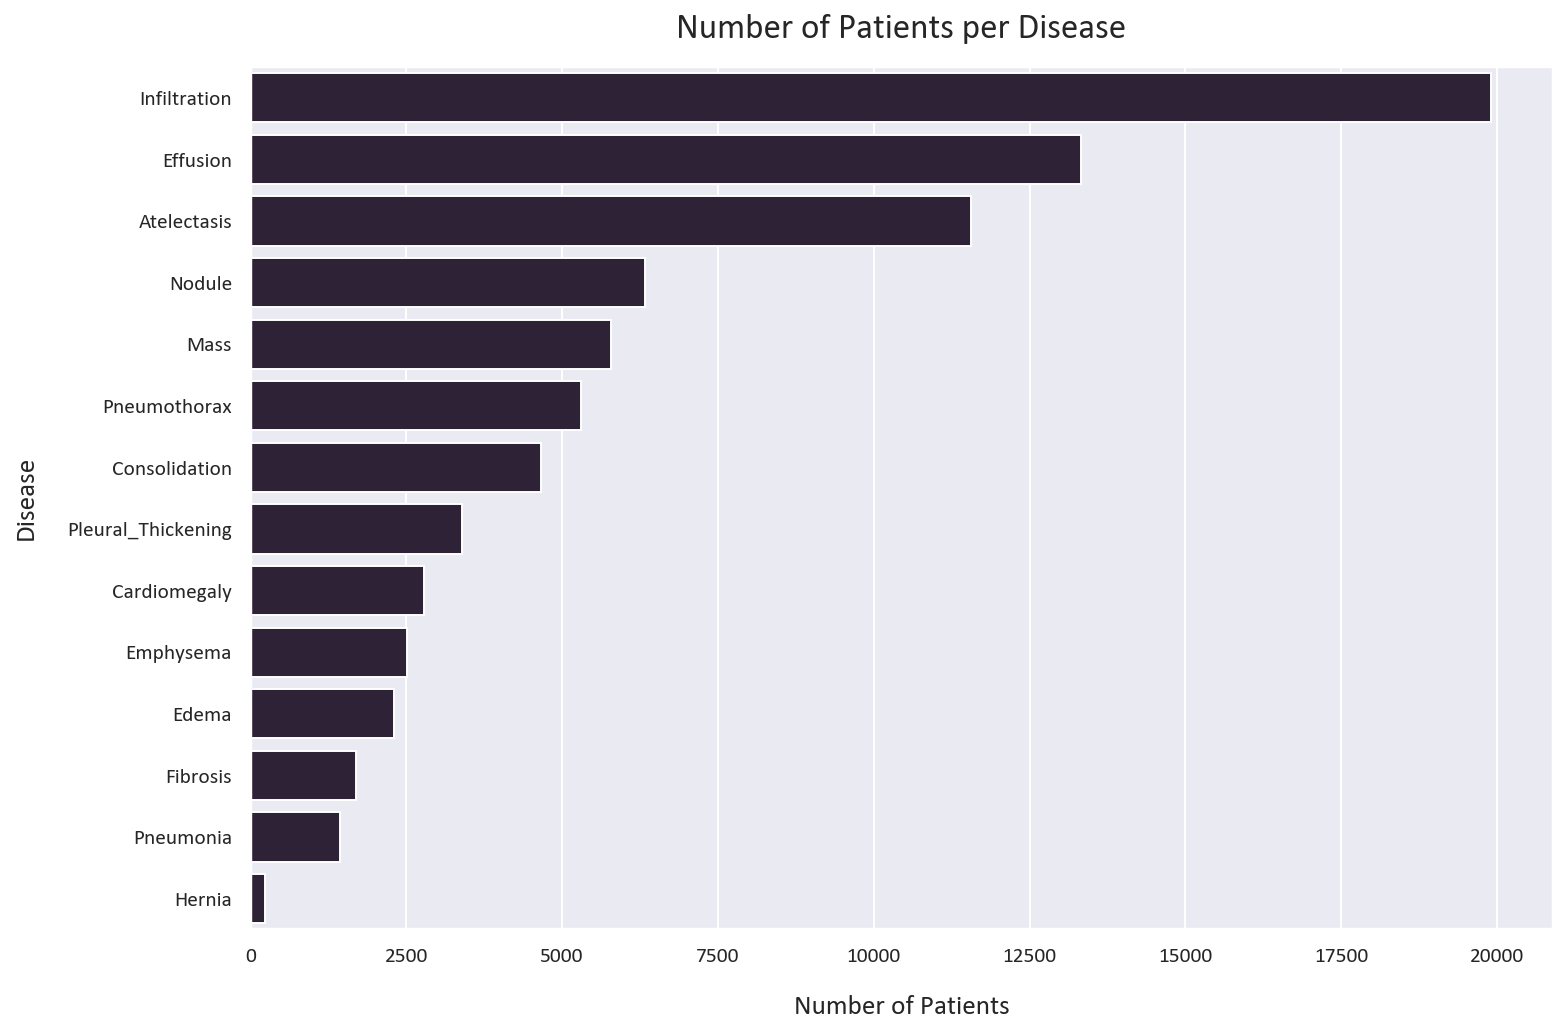

In [13]:
# What are the label counts for each disease?
label_counts = df[diseases].sum().sort_values(ascending=False)
# Plot the value counts
plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.xlabel('Number of Patients')
plt.ylabel('Disease')
plt.title('Number of Patients per Disease')

As we can notice, the data is extremely unbalanced towards the normal class. This is a common problem in medical datasets, where the number of positive samples is usually much smaller than the number of negative samples. This is a problem because most machine learning algorithms are designed to maximize accuracy and reduce error. Therefore, they tend to perform poorly on unbalanced datasets. In this case, the algorithm will tend to classify all samples as negative, resulting in a high apparent accuracy but a poor performance in the positive class.

Text(0.5, 1.0, 'Number of Diseases per Patient')

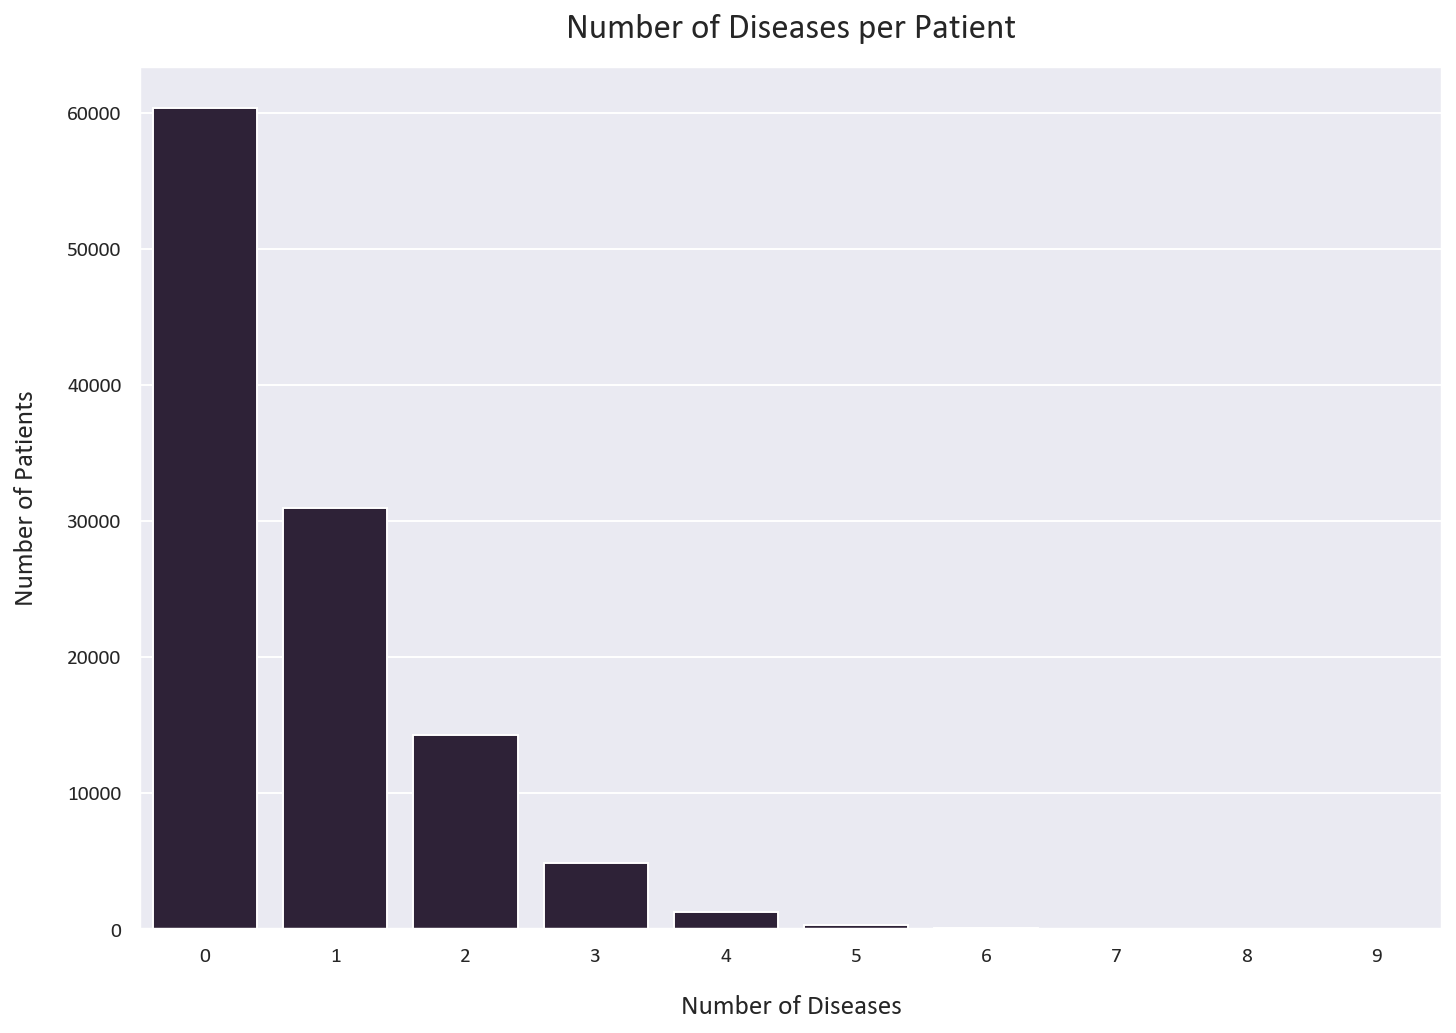

In [14]:
# How many diseases does each patient have?
label_counts = df[diseases].sum(axis=1).value_counts().sort_index()
# Plot the value counts
plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Number of Diseases')
plt.ylabel('Number of Patients')
plt.title('Number of Diseases per Patient')

What percentage is each disease in the dataset?

Text(0.5, 1.0, 'Percentage of Each Disease')

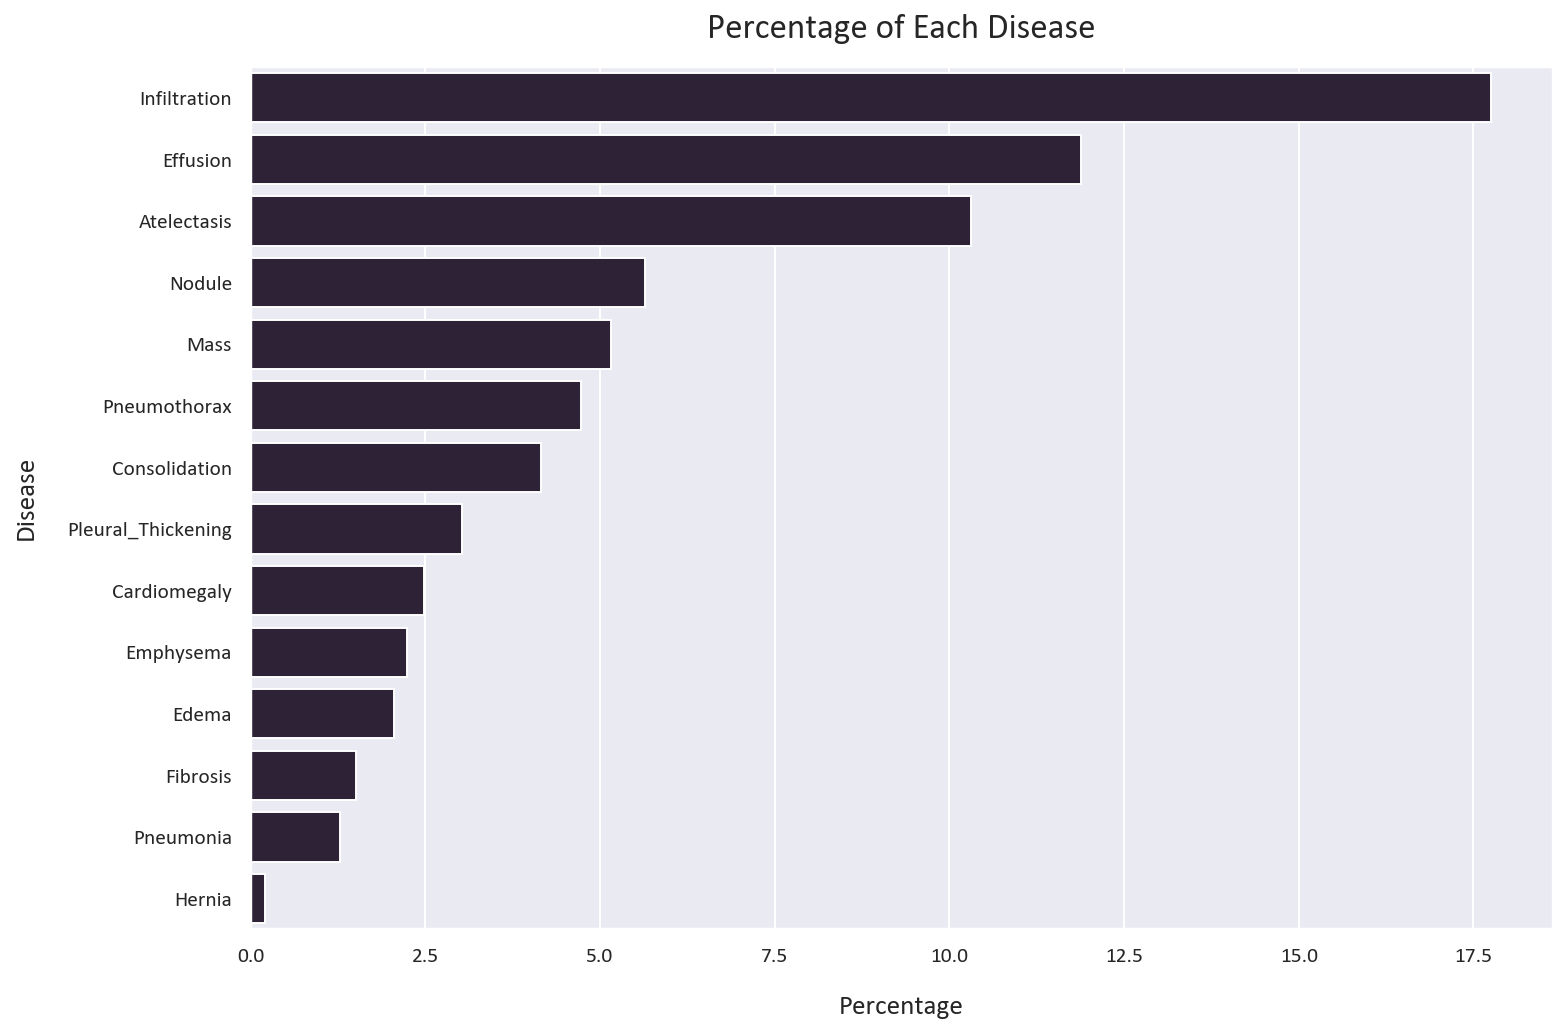

In [15]:
# Get the unique labels
unique_labels = df[diseases].sum().sort_values(ascending=False)
# Plot the percentage of each label
plt.figure(figsize=(12, 8))
sns.barplot(x=unique_labels.values / len(df) * 100, y=unique_labels.index)
plt.xlabel('Percentage')
plt.ylabel('Disease')
plt.title('Percentage of Each Disease')

We have some underrepresented diseases, namely from hernia to nodule. We will use data augmentation to increase the number of images for these diseases.

Let's visualize the positive and negative cases for each disease.

In [16]:
# Melt the dataframe to convert the diseases to rows
melted_df = pd.melt(df[diseases])

melted_df

,variable,value
0,Atelectasis,0
1,Atelectasis,0
2,Atelectasis,0
3,Atelectasis,0
4,Atelectasis,0
...,...,...
1569675,Pneumothorax,0
1569676,Pneumothorax,0
1569677,Pneumothorax,0
1569678,Pneumothorax,0


In [17]:
# Get the count of each disease
count_df = melted_df.groupby(['variable', 'value']).size().reset_index().rename(columns={0: 'count'})

# Calculate the total count for each 'variable'
total_count = count_df.groupby('variable')['count'].transform('sum')

# Calculate the percentage of each disease
count_df['Percentage'] = count_df['count'] / total_count * 100

count_df

,variable,value,count,Percentage
0,Atelectasis,0,100561,89.690510
1,Atelectasis,1,11559,10.309490
2,Cardiomegaly,0,109344,97.524081
3,Cardiomegaly,1,2776,2.475919
4,Consolidation,0,107453,95.837496
5,Consolidation,1,4667,4.162504
6,Edema,0,109817,97.945951
7,Edema,1,2303,2.054049
8,Effusion,0,98803,88.122547
9,Effusion,1,13317,11.877453


1. `melted_df.groupby(['variable', 'value']).size()`: This groups the data by 'variable' and 'value', and calculates the size of each group, which is the count of each disease.

2. `.reset_index().rename(columns={0: 'count'})`: This resets the index of the DataFrame and renames the column containing the counts to 'count'.

3. `count_df.groupby('variable')['count'].transform('sum')`: This groups the data by 'variable' and calculates the sum of the 'count' column for each group. The `transform` function returns a Series that has the same length as the original DataFrame, so you can add it as a new column.

4. `count_df['Percentage'] = count_df['count'] / total_count * 100`: This calculates the percentage of each disease by dividing the count of each disease by the total count and multiplying by 100.

The resulting DataFrame, `count_df`, contains the count and percentage of each disease in the dataset.

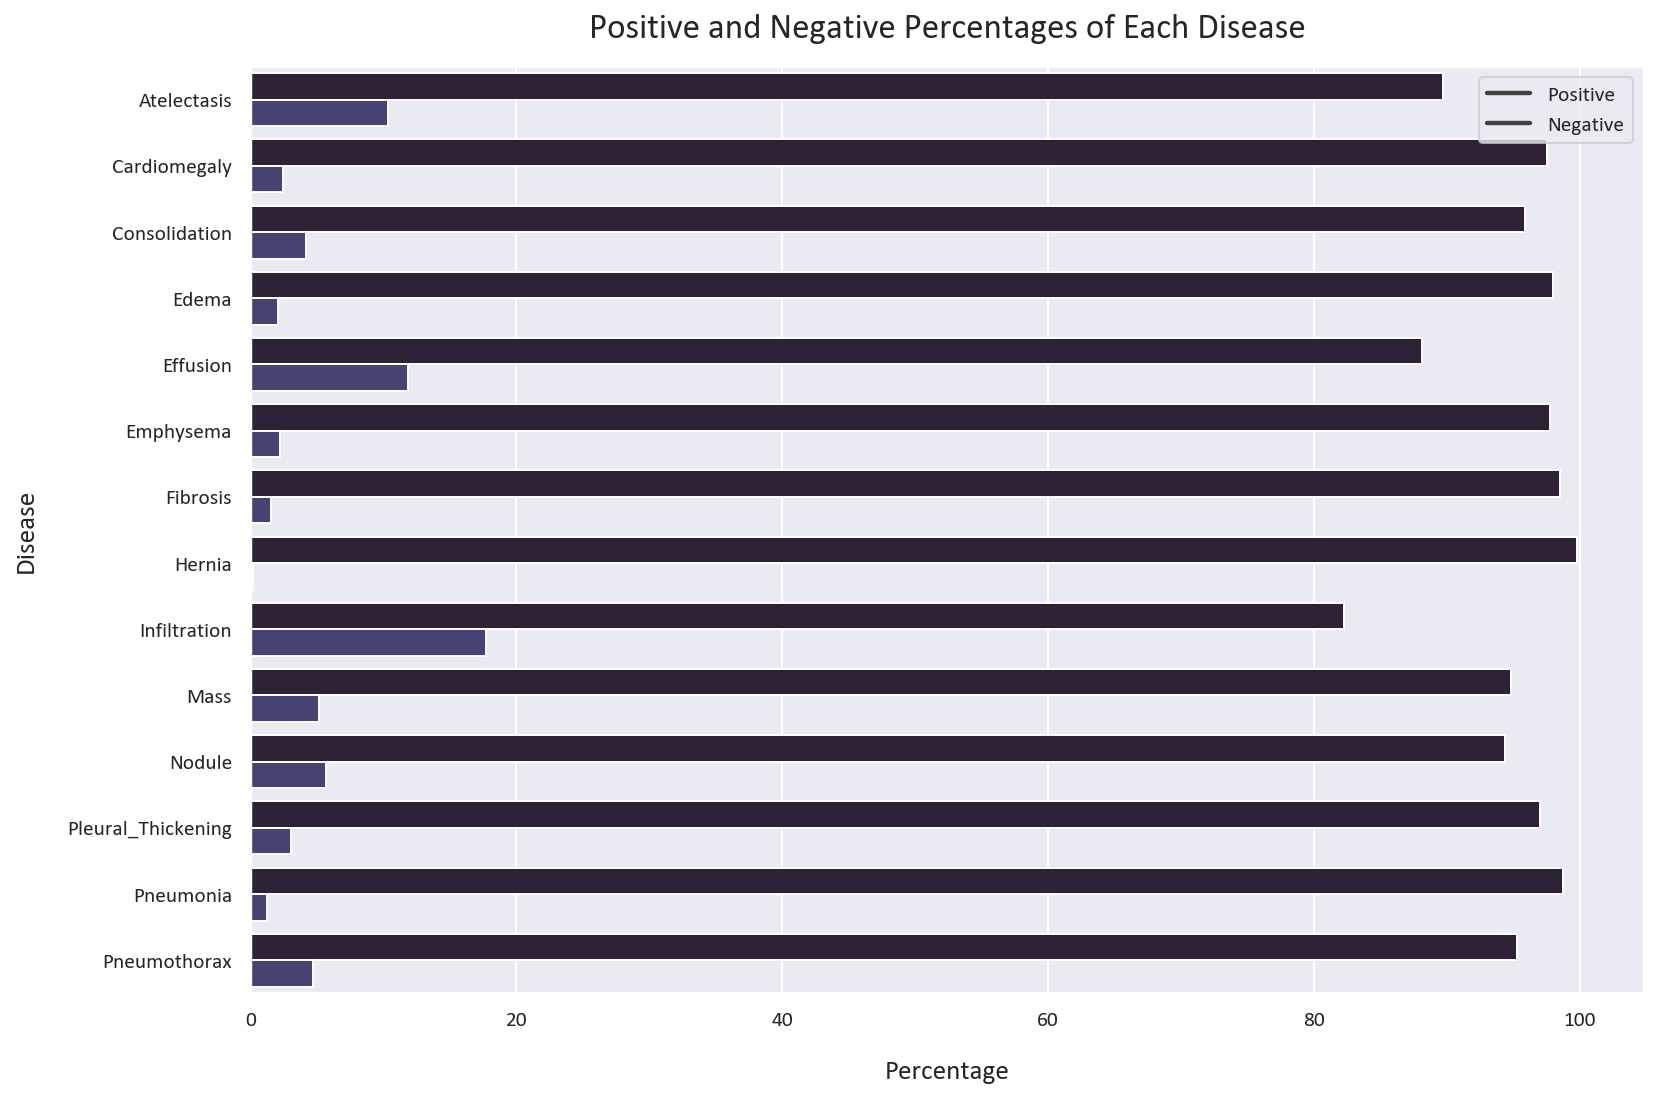

In [18]:
# Plot the percentage of each disease
plt.figure(figsize=(12, 8))
sns.barplot(x='Percentage', y='variable', hue='value', data=count_df)
plt.xlabel('Percentage')
plt.ylabel('Disease')
plt.title('Positive and Negative Percentages of Each Disease')
plt.legend(['Positive', 'Negative'])
plt.tight_layout()

As we discussed earlier, the positive cases are much less than the negative cases. If a model is trained on this dataset, it will tend to classify most cases as negative, resulting in a high apparent accuracy. However, the model will perform poorly on the positive cases, which is dangerous in the medical field. This means that the model will tend to classify most patients as healthy, even if they have a disease. This can lead to misdiagnosis and death.

This is why we need to use other metrics to evaluate the performance of our model. In this case, we will use the AUC ROC, recall, and precision metrics.
* AUC ROC: The area under the Receiver Operating Characteristic curve. It is a probability curve that plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold values and essentially separates the positive and negative cases. The higher the AUC, the better the model is at predicting positive and negative cases. This is a good metric to use for evaluating the performance of our model.

However, this metric alone could be deceiving. For example, if we have a dataset with 99% negative cases and 1% positive cases, a model that classifies all cases as negative will have a high AUC ROC. This is because the model will have a high True Negative Rate (TN) and a low False Positive Rate (FP). However, this model will perform poorly on the positive cases. This is why we need to use other metrics as well. [This article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9006654/) explains this in more detail

* Precision: The number of true positives divided by the number of true positives and false positives. It is the ability of the classifier to not label a negative sample as positive. A high precision means that the classifier will not label a negative sample as positive very often. This will prevent false positives, where a patient is diagnosed with a disease when they do not have it. However, a high precision can lead to false negatives, where a patient is told they do not have a disease when they actually do. This is dangerous and can lead to misdiagnosis and death.

* Recall: The number of true positives divided by the number of true positives and false negatives. It is the ability of the classifier to find all positive samples. A high recall means that the classifier will not miss a positive sample very often. This will prevent false negatives, where a patient is told they do not have a disease when they actually do. However, a high recall can lead to false positives, where a patient is diagnosed with a disease when they do not have it. This is less dangerous than false negatives, as these patients are usually sent for further testing to confirm the diagnosis.



In [19]:
# Drop the 'Finding Labels' column
df = df.drop('Finding Labels', axis=1)

# Display the first 5 rows of the dataframe
df.head()

,Image Path,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,data/images_001/images\00000001_000.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,data/images_001/images\00000001_001.png,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,data/images_001/images\00000001_002.png,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,data/images_001/images\00000002_000.png,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,data/images_001/images\00000003_000.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Next, we have to deal with data leak, which is a very common problem in medical datasets. Data leak happens when the same patient is present in both the training and testing datasets. This is a problem because the model will learn to recognize the patient instead of the disease. This will result in high accuracy but poor performance in the real world.

In this case, we must make sure that the training, validation, and testing datasets are completely separated. We will use the patient ID to separate the datasets. We will first split the dataset into training and testing datasets. Then, we will split the training dataset into training and validation datasets. This will ensure that the same patient is not present in two different datasets.

## 3. Data Preprocessing and Data Augmentation

In [20]:
# Define the image size and batch size
IMG_SIZE = [224, 224]
BATCH_SIZE = 32

# Get unique patient IDs
patient_ids = df['Patient ID'].unique()

We will be using a 60/20/20 split for the training, validation, and testing datasets as we will be augmenting the training dataset.

In [21]:
# Split the patient IDs into train, validation, and test sets
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=0)
train_ids, val_ids = train_test_split(train_ids, test_size=0.26, random_state=0) # 0.26 x 0.8 ~= 0.2

# Create dataframes for train, validation, and test sets
train_df = df[df['Patient ID'].isin(train_ids)]
val_df = df[df['Patient ID'].isin(val_ids)]
test_df = df[df['Patient ID'].isin(test_ids)]

# Check the shapes of the dataframes
print('train_df shape:', train_df.shape)
print('val_df shape:', val_df.shape)
print('test_df shape:', test_df.shape)

# Check the ratios of the dataframes as we split based on patient IDs, not individual images
print('train_df ratio:', round(len(train_df) / len(df), 3))
print('val_df ratio:', round(len(val_df) / len(df), 3))
print('test_df ratio:', round(len(test_df) / len(df), 3))

train_df shape: (66543, 16)
val_df shape: (23514, 16)
test_df shape: (22063, 16)
train_df ratio: 0.593
val_df ratio: 0.21
test_df ratio: 0.197


In [22]:
# Drop the 'Patient ID' column
train_df = train_df.drop('Patient ID', axis=1).reset_index(drop=True)
val_df = val_df.drop('Patient ID', axis=1).reset_index(drop=True)
test_df = test_df.drop('Patient ID', axis=1).reset_index(drop=True)

# Inspect the dataframes
train_df.info(), val_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66543 entries, 0 to 66542
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image Path          66543 non-null  object
 1   Atelectasis         66543 non-null  int64 
 2   Cardiomegaly        66543 non-null  int64 
 3   Consolidation       66543 non-null  int64 
 4   Edema               66543 non-null  int64 
 5   Effusion            66543 non-null  int64 
 6   Emphysema           66543 non-null  int64 
 7   Fibrosis            66543 non-null  int64 
 8   Hernia              66543 non-null  int64 
 9   Infiltration        66543 non-null  int64 
 10  Mass                66543 non-null  int64 
 11  Nodule              66543 non-null  int64 
 12  Pleural_Thickening  66543 non-null  int64 
 13  Pneumonia           66543 non-null  int64 
 14  Pneumothorax        66543 non-null  int64 
dtypes: int64(14), object(1)
memory usage: 7.6+ MB
<class 'pandas.core.fram

(None, None, None)

In [23]:
# Calculate the percentages of each disease in the train, validation, and test sets
train_percentages = train_df[diseases].mean() * 100
val_percentages = val_df[diseases].mean() * 100
test_percentages = test_df[diseases].mean() * 100

# Create a DataFrame that contains the calculated percentages
percentage_df = pd.DataFrame({
    'Disease': diseases,
    'Train': train_percentages,
    'Validation': val_percentages,
    'Test': test_percentages
})

# Melt the DataFrame from wide format to long format for plotting
percentage_df = percentage_df.melt(id_vars='Disease', var_name='Set', value_name='Percentage')

percentage_df

,Disease,Set,Percentage
0,Atelectasis,Train,10.327157
1,Cardiomegaly,Train,2.455555
2,Consolidation,Train,4.101108
3,Edema,Train,1.980674
4,Effusion,Train,11.337030
5,Emphysema,Train,2.419488
6,Fibrosis,Train,1.534346
7,Hernia,Train,0.264491
8,Infiltration,Train,17.790000
9,Mass,Train,4.989255


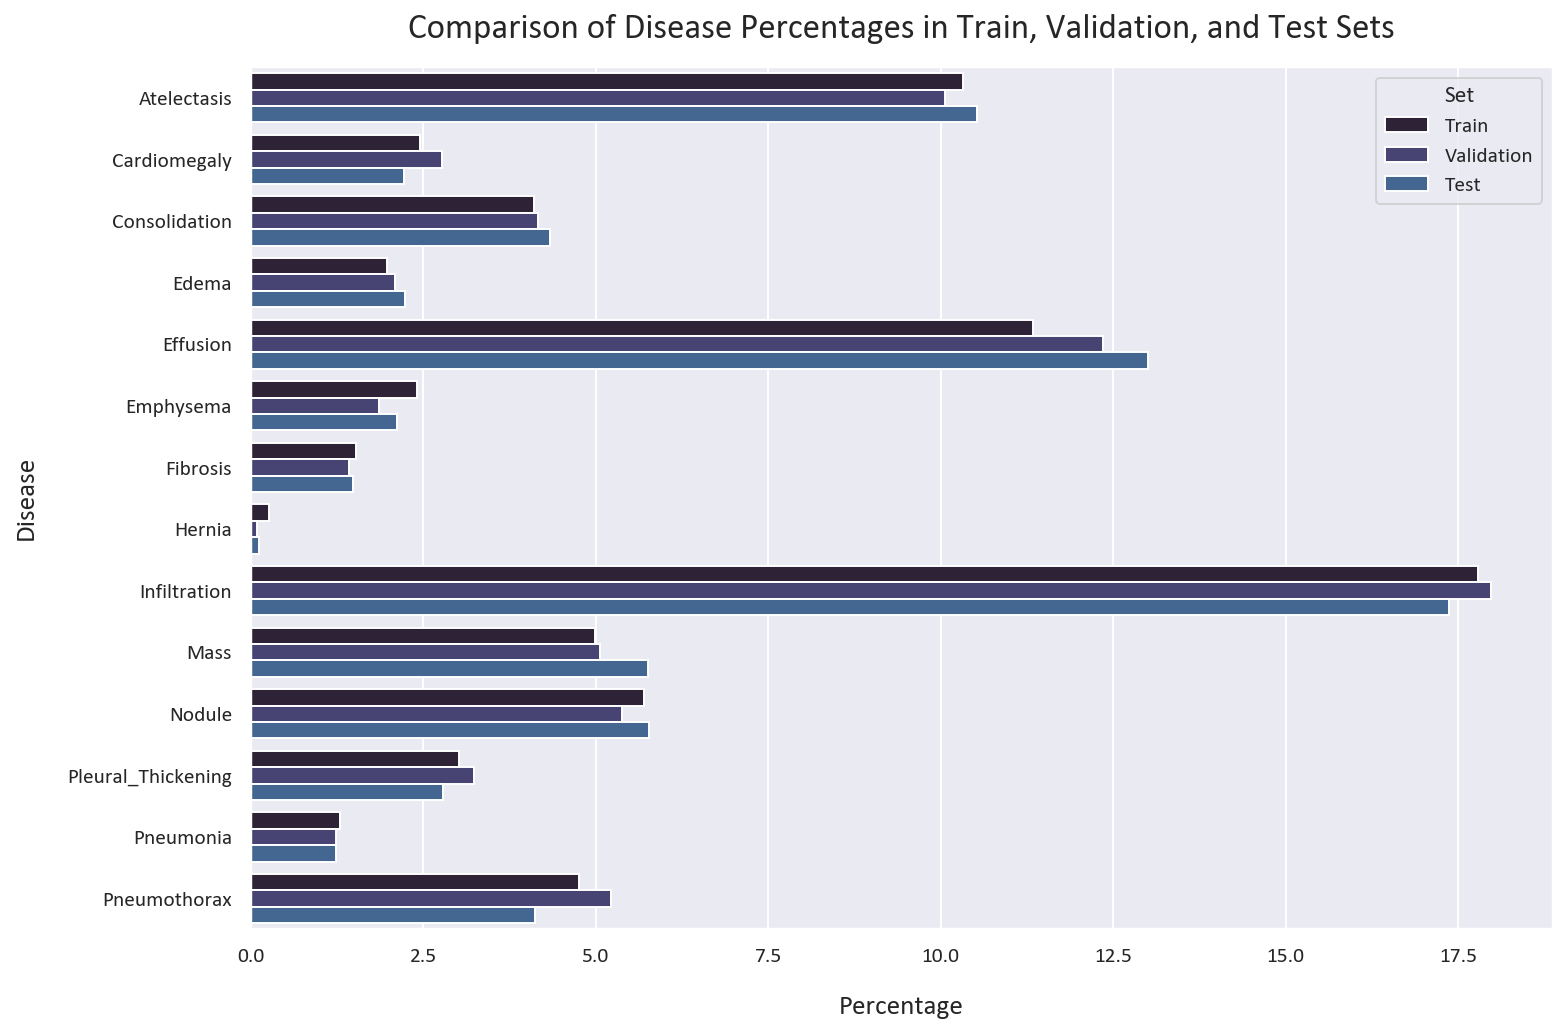

In [24]:
# Create a bar plot that compares the percentages of each disease in the train, validation, and test sets
plt.figure(figsize=(12, 8))
sns.barplot(data=percentage_df, x='Percentage', y='Disease', hue='Set', alpha=1)
plt.title('Comparison of Disease Percentages in Train, Validation, and Test Sets')
plt.show()

The distribution of the classes is similar in all datasets. This is good, as we want to have a similar distribution of the classes in all datasets.

In [25]:
# Inspect disease class percentages
count_df

,variable,value,count,Percentage
0,Atelectasis,0,100561,89.690510
1,Atelectasis,1,11559,10.309490
2,Cardiomegaly,0,109344,97.524081
3,Cardiomegaly,1,2776,2.475919
4,Consolidation,0,107453,95.837496
5,Consolidation,1,4667,4.162504
6,Edema,0,109817,97.945951
7,Edema,1,2303,2.054049
8,Effusion,0,98803,88.122547
9,Effusion,1,13317,11.877453


In [26]:
class_weights = []

for i, disease in enumerate(diseases):
    # Count the number of positive and negative instances for this disease
    n_positive = np.sum(train_df[disease])
    n_negative = len(train_df) - n_positive

    # Compute the weight for positive instances and the weight for negative instances
    weight_for_positive = (1 / n_positive) * (len(train_df) / 2.0)
    weight_for_negative = (1 / n_negative) * (len(train_df) / 2.0)

    class_weights.append({0: weight_for_negative, 1: weight_for_positive})

# Now class_weights is a list of dictionaries, where each dictionary contains the weights for one disease
class_weights

[{0: 0.5575824102160178, 1: 4.841603608847497},
 {0: 0.5125868523625383, 1: 20.361995104039167},
 {0: 0.5213824552606011, 1: 12.191828508611213},
 {0: 0.5101034879264086, 1: 25.24393019726859},
 {0: 0.5639332870048644, 1: 4.410326086956522},
 {0: 0.5123973942371368, 1: 20.66552795031056},
 {0: 0.5077912762125698, 1: 32.5871694417238},
 {0: 0.5013259601910588, 1: 189.04261363636365},
 {0: 0.6081985193309569, 1: 2.810567663456665},
 {0: 0.5262562674975879, 1: 10.021536144578315},
 {0: 0.5302062085670577, 1: 8.776444209970984},
 {0: 0.5155494607660841, 1: 16.577727952167415},
 {0: 0.5065928711725566, 1: 38.41974595842956},
 {0: 0.5249775155024694, 1: 10.509001895135818}]

Here's a step-by-step explanation of the code:

1. For each disease in the `diseases` list, it counts the number of positive instances (`n_positive`) and negative instances (`n_negative`).

2. It then calculates the weight for positive instances (`weight_for_positive`) and the weight for negative instances (`weight_for_negative`). The weight is inversely proportional to the number of instances, meaning that less frequent classes will have a higher weight. This will give more importance to under-represented classes during training. It then multiplies the weights by half of the total number of instances as there are two classes (0 and 1).


By dividing the total number of instances (`len(train_df)`) by 2, we're effectively allocating half of the total weight to the positive instances and the other half to the negative instances. 

This way, when the weights are applied during model training, the model sees as if it's dealing with a balanced dataset, where the positive and negative classes have an equal total weight.


3. It stores the weights for each class (0 and 1) in a dictionary and appends this dictionary to the `class_weights` list.

The resulting `class_weights` list is a list of dictionaries, where each dictionary contains the weights for one disease. These weights can be used in the `fit` method of a Keras model via the `class_weight` argument to give more importance to under-represented classes during training.

In [27]:
# Define a function to load the images
def load_image(image_path, size=IMG_SIZE):
    """
    Load the image from the given path and resize it to the given size.
    """
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the JPEG image to a tensor
    image = tf.image.decode_jpeg(image, channels=1) # This is a grayscale image, so we only have 1 channel
    # Resize the image
    image = tf.image.resize(image, size)
    return image

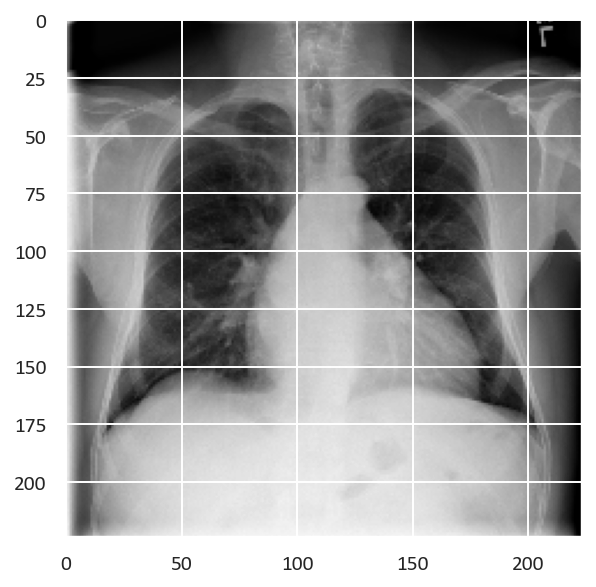

In [28]:
# Test the function
image = load_image(train_df['Image Path'][0])
# Display the image
plt.imshow(image, cmap='gray')

Okay, the function looks good.

Next, we will standardize the images. We will use the mean and standard deviation of the training dataset to standardize the training, validation, and testing datasets. This is because we want to simulate the real world, where we only have the training dataset and we want to use it to standardize the validation and testing datasets.

Standardizing the images is a common preprocessing step in image processing tasks. It helps to make the model less sensitive to the scale of features, which can be particularly important for images that have pixel intensity values in different ranges. 

By standardizing, we ensure that the pixel intensity values have a mean of 0 and a standard deviation of 1. This can help the model converge faster during training and can also lead to better performance, as the optimizer can more easily find a good solution in a standardized space.

Standardization also helps to ensure that the initial weights are in a good range to start with, which can prevent issues with vanishing or exploding gradients during backpropagation.

In [29]:
# Load the training images as numpy arrays to extract the mean and standard deviation
train_images = np.stack([load_image(path) for path in train_df['Image Path']], axis=0)

In [30]:
# Check the shape of the training images
train_images.shape

(66543, 224, 224, 1)

In [31]:
# Get the mean and standard deviation of the training images
train_mean = np.mean(train_images)
train_std = np.std(train_images)
# Print the mean and standard deviation
print('Mean:', train_mean)
print('Standard Deviation:', train_std)

Mean: 126.91178
Standard Deviation: 63.583813


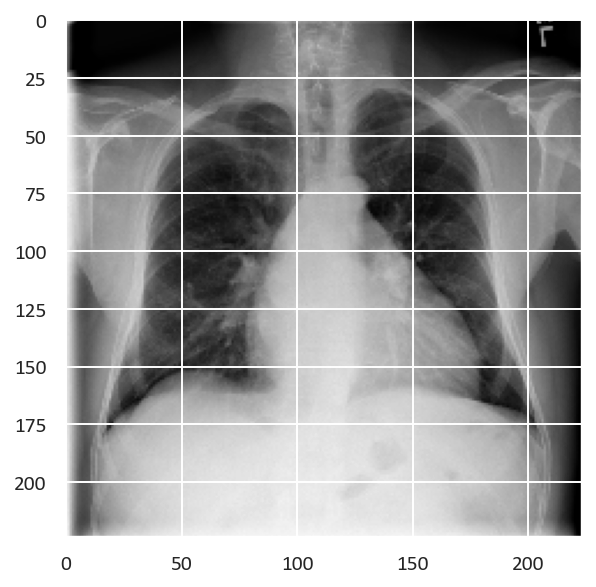

In [32]:
# Plot an image from the training set
plt.imshow(train_images[0, :, :, 0], cmap='gray')

In [33]:
# Define the train dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df['Image Path'].values, train_df[diseases].values))
# Map the load_image function to the train dataset
train_ds = train_ds.map(lambda x, y: (load_image(x), y))
# Standardize the images
train_ds = train_ds.map(lambda x, y: ((x - train_mean) / train_std, y))

Next, we will augment the underrepresented diseases using augmentation layers from the `tensorflow.keras.layers.experimental.preprocessing` module.

In [34]:
# Define the underrepresented diseases
underrepresented_diseases = ['Hernia', 'Pneumonia', 'Fibrosis', 'Emphysema', 'Pleural_Thickening', 'Cardiomegaly', 'Pleural_Thickening', 'Consolidation', 'Pneumothorax', 'Mass', 'Nodule']
# Define the data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

# Define the indices of the underrepresented diseases
underrepresented_diseases_indices = [diseases.index(disease) for disease in underrepresented_diseases]


In [35]:
# Define a function to augment the images
def augment_images(image, label):
    ''' 
    Augments the images of the underrepresented diseases.
    '''
    def augment():
        return data_augmentation(image), label

    def not_augment():
        return image, label

    for i in underrepresented_diseases_indices:
        condition = tf.equal(tf.gather(label, i), 1)
        image, label = tf.cond(condition, augment, not_augment)

    return image, label

# Create a new dataset with only the underrepresented diseases
underrepresented_ds = train_ds.filter(lambda image, label: tf.reduce_any([tf.equal(label[i], 1) for i in underrepresented_diseases_indices]))

# Augment the underrepresented dataset
augmented_ds = underrepresented_ds.map(augment_images)

# Concatenate the original dataset with the augmented dataset
train_ds_augmented = train_ds.concatenate(augmented_ds)

# Shuffle and batch the augmented dataset
train_ds_augmented = train_ds_augmented.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

The `augment_images` function is designed to augment images that belong to underrepresented diseases in the dataset. Here's a detailed breakdown:

- The function takes two arguments: `image` and `label`. The `image` is the input image that may be augmented, and `label` is the corresponding label indicating the disease.

- Two inner functions are defined: `augment` and `not_augment`. The `augment` function applies a `data_augmentation` function to the `image` and returns the augmented image along with its `label`. The `not_augment` function simply returns the `image` and `label` without any changes.

- The function then iterates over the indices of the underrepresented diseases (`underrepresented_diseases_indices`). For each index, it checks if the label at that index is 1 (indicating that the image belongs to that disease).

- The `tf.equal(tf.gather(label, i), 1)` operation checks if the `i`-th disease is present in the `label`. If it is (`tf.equal` returns `True`), the `condition` is `True`.

- `tf.cond(condition, augment, not_augment)` is a conditional operation that executes `augment` if the `condition` is `True` and `not_augment` if the `condition` is `False`. 

- If the `condition` is `True`, the `augment` function is called, and the image is augmented. If the `condition` is `False`, the `not_augment` function is called, and the image is not augmented.

- The function finally returns the (possibly augmented) `image` and its `label`.


In [36]:
# Check the shape of the images and labels
for images, labels in train_ds_augmented.take(1):
    print('Images:', images.shape)
    print('Labels:', labels.shape)

Images: (32, 224, 224, 1)
Labels: (32, 14)


In [37]:
# How many training images do we have?
num_batches = sum([1 for _ in train_ds_augmented])
print(num_batches * BATCH_SIZE)

83008


In [38]:
# Define the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_df['Image Path'].values, val_df[diseases].values))
# Map the load_image function to the validation dataset
val_ds = val_ds.map(lambda x, y: (load_image(x), y))
# Standardize the images
val_ds = val_ds.map(lambda x, y: ((x - train_mean) / train_std, y))
# Batch the dataset
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [39]:
# Define the test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_df['Image Path'].values, test_df[diseases].values))
# Map the load_image function to the test dataset
test_ds = test_ds.map(lambda x, y: (load_image(x), y))
# Standardize the images
test_ds = test_ds.map(lambda x, y: ((x - train_mean) / train_std, y))
# Batch the dataset
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

## 4. Model Building and Evaluation

As this is an image classification problem, we will use a convolutional neural network (CNN).

In [38]:
# Define the model
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (7, 7), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Batch normalization layer normalizes the output of the previous layer by subtracting the batch mean and dividing by the batch standard deviation.
    # This layer helps to stabilize the learning process and dramatically increases the speed of convergence.
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (7, 7), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (7, 7), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (7, 7), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Global average pooling layer reduces each feature map to a single number by simply taking the average of all the values in the feature map. 
    # This layer helps to reduce the number of parameters, prevent overfitting, and allow the model to generalize better.
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(diseases), activation='sigmoid')
])

I used a larger kernel size of 7x7 for the first convolutional layer. This is because larger kernel sizes can be beneficial in medical imaging tasks for the following reasons:

1. **Coverage**: A larger kernel size means that the convolution operation covers a larger area of the input image. This can be beneficial when the important features in the image are large or spread out, which is often the case in X-ray images where the disease markers can be spread across the image.

2. **Context**: Larger kernels can capture more context. In medical imaging, the context around a certain area can provide important information about the presence or absence of a disease.

3. **Noise Reduction**: Larger kernels can also act as a noise reduction mechanism, as they average more pixels together. This can be beneficial in medical imaging, where images can often contain noise.

However, it's important to note that larger kernels come with their own trade-offs. They are more computationally expensive and may miss finer details that smaller kernels could capture. Therefore, the choice of kernel size should be based on the specific task and nature of the input data, and often involves a process of experimentation and validation. I found that a kernel size of 7x7 worked well for this task.

In [41]:
from keras import backend as K
def create_weighted_binary_crossentropy(class_weights):
    def weighted_binary_crossentropy(y_true, y_pred):
        # Cast the true label to float32
        y_true = tf.cast(y_true, tf.float32)

        # Calculate the binary cross-entropy loss
        bce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights for each class
        weighted_bce = 0
        for i in range(len(class_weights)):
            weights = y_true[:, i] * class_weights[i][1] + (1. - y_true[:, i]) * class_weights[i][0]
            weighted_bce += weights * bce[:, i]

        return K.mean(weighted_bce)
    
    return weighted_binary_crossentropy

Here's a step-by-step explanation for the custom loss function:

1. The function `create_weighted_binary_crossentropy` is defined with one parameter: `class_weights`. This is a list of dictionaries, where each dictionary contains the weights for one disease.

2. Inside this function, another function `weighted_binary_crossentropy` is defined. This function calculates the weighted binary cross-entropy loss for the predictions. It takes two parameters: `y_true` and `y_pred`, which represent the true labels and the predicted labels, respectively.

3. `y_true` is cast to `tf.float32` to ensure that the calculations are done in floating point numbers.

4. The binary cross-entropy loss `bce` is calculated using `K.binary_crossentropy(y_true, y_pred)`. This function calculates the binary cross-entropy between the true labels and the predicted labels.

5. An empty variable `weighted_bce` is initialized to store the weighted binary cross-entropy loss.

6. A for loop is used to iterate over the range of the length of `class_weights`. For each class, it calculates the weights for the positive and negative instances. This is done by multiplying the true labels for the class(the positive instances) (`y_true[:, i]`) with the weight for the positive instances (`class_weights[i][1]`) and adding the result to the product of the complement of the true labels(which would be the negative instances) (`1. - y_true[:, i]`) and the weight for the negative instances (`class_weights[i][0]`).

7. The calculated weights are then multiplied with the binary cross-entropy loss for the class (`bce[:, i]`) and added to `weighted_bce`.

8. After the for loop, the function returns the mean of the weighted binary cross-entropy loss using `K.mean(weighted_bce)`.

9. Finally, `create_weighted_binary_crossentropy` returns the `weighted_binary_crossentropy` function. This allows me to create a custom loss function with specific class weights, which I can then pass to the `compile` method of my model.



In [40]:
# Define the AUC metric
AUC = tf.keras.metrics.AUC(multi_label=True, name='auc')

# Compile the model
model_cnn.compile(loss=create_weighted_binary_crossentropy(class_weights),
              optimizer='adam',
              metrics=['binary_accuracy', AUC, tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])

# Print the model summary
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 16)      800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 109, 109, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 103, 103, 32)      25120     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 51, 51, 32)       0         
 2D)                                                             
                                                      

 conv2d_2 (Conv2D)           (None, 45, 45, 64)        100416    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 22, 22, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       401536    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
          

In [41]:
# Define the number of epochs
EPOCHS = 20

In [42]:
# Train the model
history_cnn = model_cnn.fit(train_ds_augmented,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
                    tf.keras.callbacks.ModelCheckpoint('models/model-weighted-binary-crossentropy.keras', monitor='val_loss', save_best_only=True, verbose=1),
                    tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.95 ** epoch, verbose=1)
])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
   2594/Unknown - 138s 53ms/step - loss: 10.3165 - binary_accuracy: 0.5362 - auc: 0.7070 - recall: 0.7286 - precision: 0.0986
Epoch 1: val_loss improved from inf to 11.63515, saving model to models\model-weighted-binary-crossentropy.keras
2594/2594 [==============================] - 153s 58ms/step - loss: 10.3165 - binary_accuracy: 0.5362 - auc: 0.7070 - recall: 0.7286 - precision: 0.0986 - val_loss: 11.6352 - val_binary_accuracy: 0.2653 - val_auc: 0.6461 - val_recall: 0.7164 - val_precision: 0.0493 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.00095.
Epoch 2/20
2591/2594 [============================>.] - ETA: 0s - loss: 10.0310 - binary_accuracy: 0.5204 - auc: 0.7281 - recall: 0.7651 - precision: 0.0993
Epoch 2: val_loss improved from 11.63515 to 10.85679, saving model to models\model-weighted-binary-crossentropy.keras
2594/2594 [==============================] - 148s 57ms/step - loss

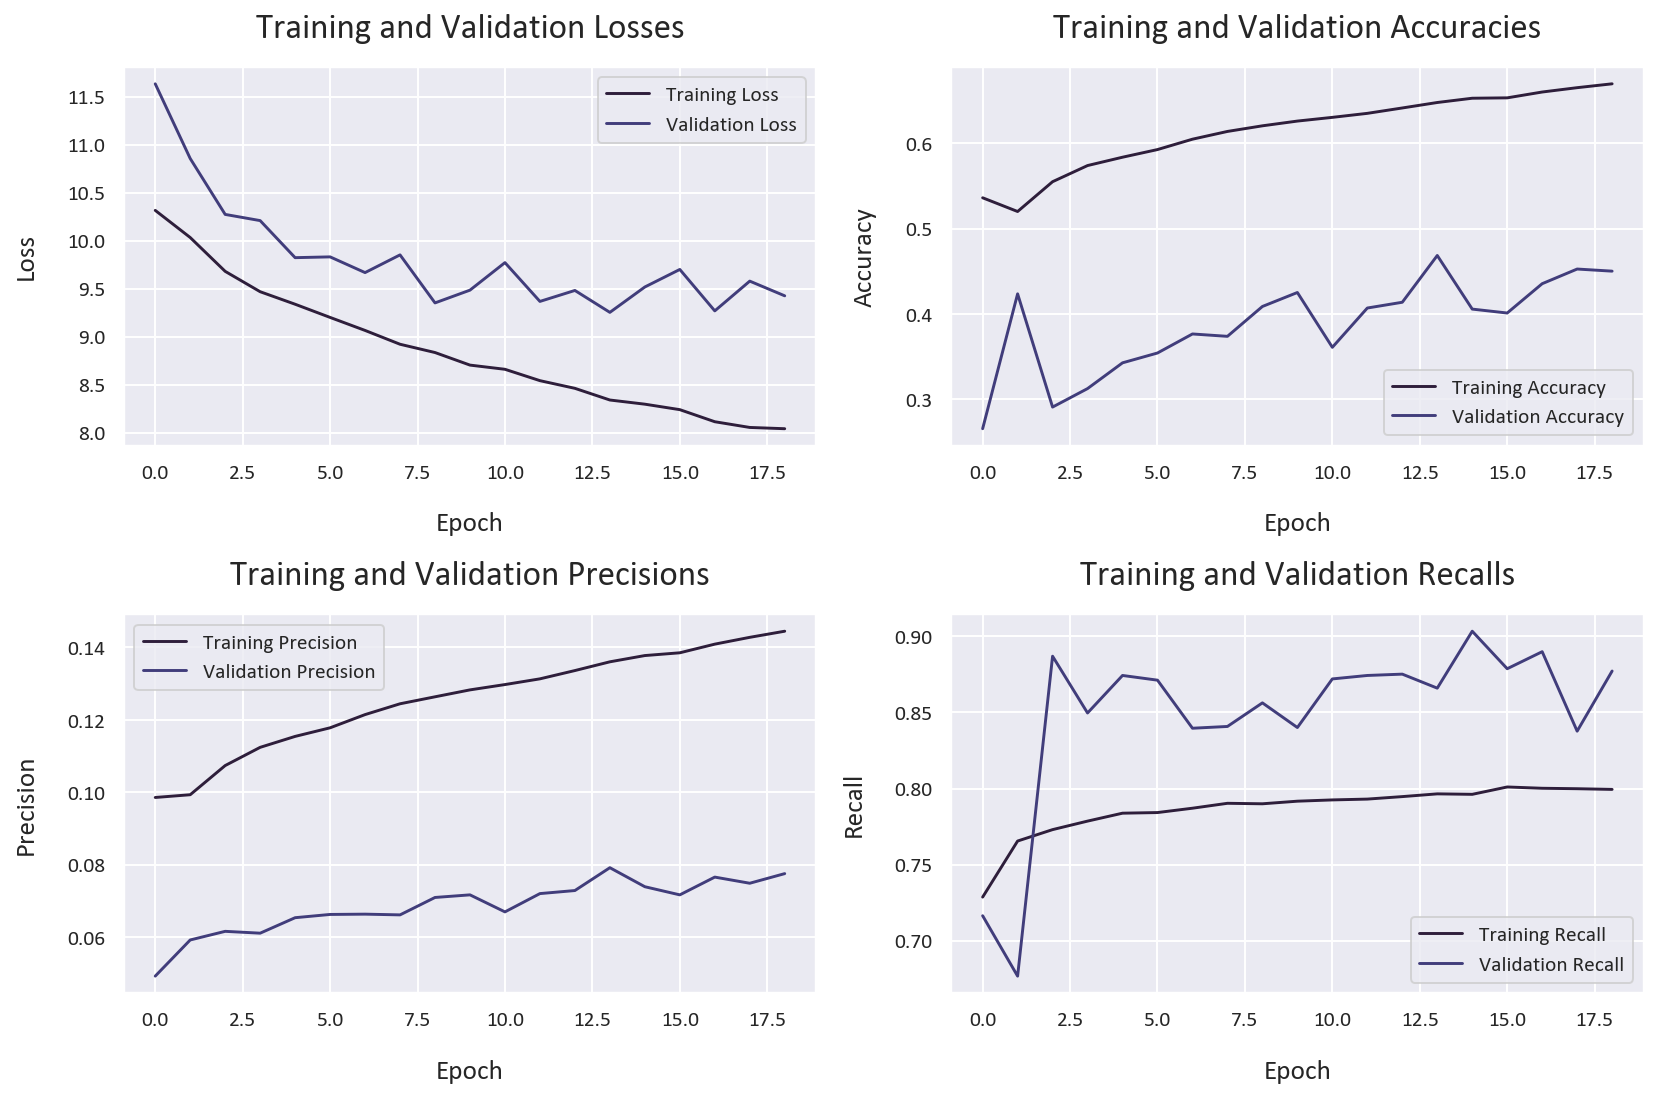

In [45]:
# Plot the training and validation metrics
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.subplot(2, 2, 2)
plt.plot(history_cnn.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_binary_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.subplot(2, 2, 3)
plt.plot(history_cnn.history['precision'], label='Training Precision')
plt.plot(history_cnn.history['val_precision'], label='Validation Precision')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precisions')
plt.subplot(2, 2, 4)
plt.plot(history_cnn.history['recall'], label='Training Recall')
plt.plot(history_cnn.history['val_recall'], label='Validation Recall')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recalls')
plt.tight_layout()

In [42]:
# Load the best model
model_cnn = tf.keras.models.load_model(
    'models/model-weighted-binary-crossentropy.keras', 
    custom_objects={'weighted_binary_crossentropy': create_weighted_binary_crossentropy(class_weights)}
)
# Compute the predictions
predictions_cnn = model_cnn.predict(test_ds)

690/690 [==============================] - 12s 18ms/step


In [60]:
from sklearn.metrics import roc_curve, auc

# Initialize dictionaries
fpr_dict_wbc = {}
tpr_dict_wbc = {}
auc_dict_wbc = {}

# Compute the ROC curve and AUC score for each disease
for i, disease in enumerate(diseases):
    fpr, tpr, _ = roc_curve(test_df[disease], predictions_cnn[:, i])
    auc_score = auc(fpr, tpr)
    
    fpr_dict_wbc[disease] = fpr
    tpr_dict_wbc[disease] = tpr
    auc_dict_wbc[disease] = auc_score


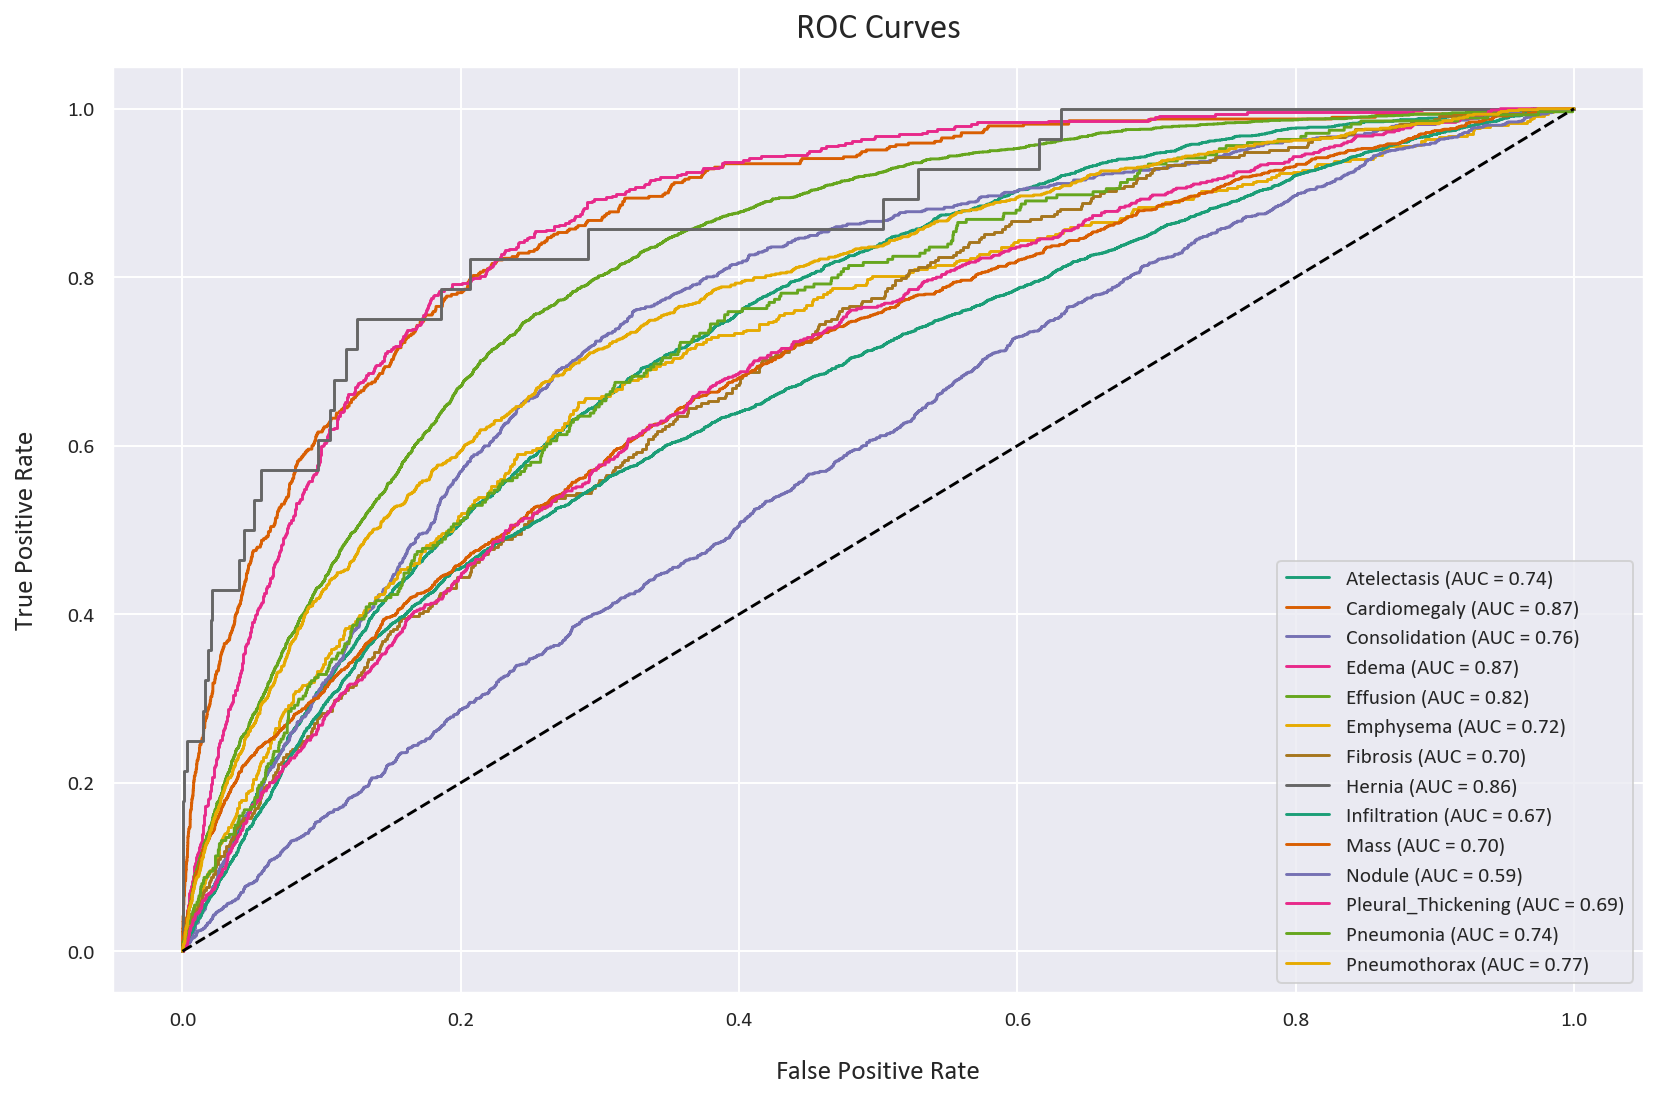

In [62]:
# Plot the ROC curves
plt.figure(figsize=(12, 8))
with sns.color_palette("Dark2"):
    for disease in diseases:
        plt.plot(fpr_dict_wbc[disease], tpr_dict_wbc[disease], label=f'{disease} (AUC = {auc_dict_wbc[disease]:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
# Compile the model using binary cross-entropy loss
model_cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy', AUC, tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])

In [54]:
# Train the model
history_cnn_2 = model_cnn.fit(train_ds_augmented,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
                    tf.keras.callbacks.ModelCheckpoint('models/model-binary_crossentropy.keras', monitor='val_loss', save_best_only=True, verbose=1),
                    tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.95 ** epoch, verbose=1)])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20


   2591/Unknown - 138s 53ms/step - loss: 0.2202 - binary_accuracy: 0.9169 - auc: 0.6840 - recall: 0.0670 - precision: 0.1777
Epoch 1: val_loss improved from inf to 0.20106, saving model to models\model-binary_crossentropy.keras
2594/2594 [==============================] - 152s 58ms/step - loss: 0.2203 - binary_accuracy: 0.9169 - auc: 0.6840 - recall: 0.0670 - precision: 0.1779 - val_loss: 0.2011 - val_binary_accuracy: 0.9392 - val_auc: 0.7346 - val_recall: 0.0775 - val_precision: 0.2404 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.00095.
Epoch 2/20
2591/2594 [============================>.] - ETA: 0s - loss: 0.1901 - binary_accuracy: 0.9336 - auc: 0.8158 - recall: 0.0583 - precision: 0.5262
Epoch 2: val_loss improved from 0.20106 to 0.19896, saving model to models\model-binary_crossentropy.keras
2594/2594 [==============================] - 152s 58ms/step - loss: 0.1902 - binary_accuracy: 0.9335 - auc: 0.8158 - recall: 0.0584 - precision: 0.5263 - val_loss: 0.

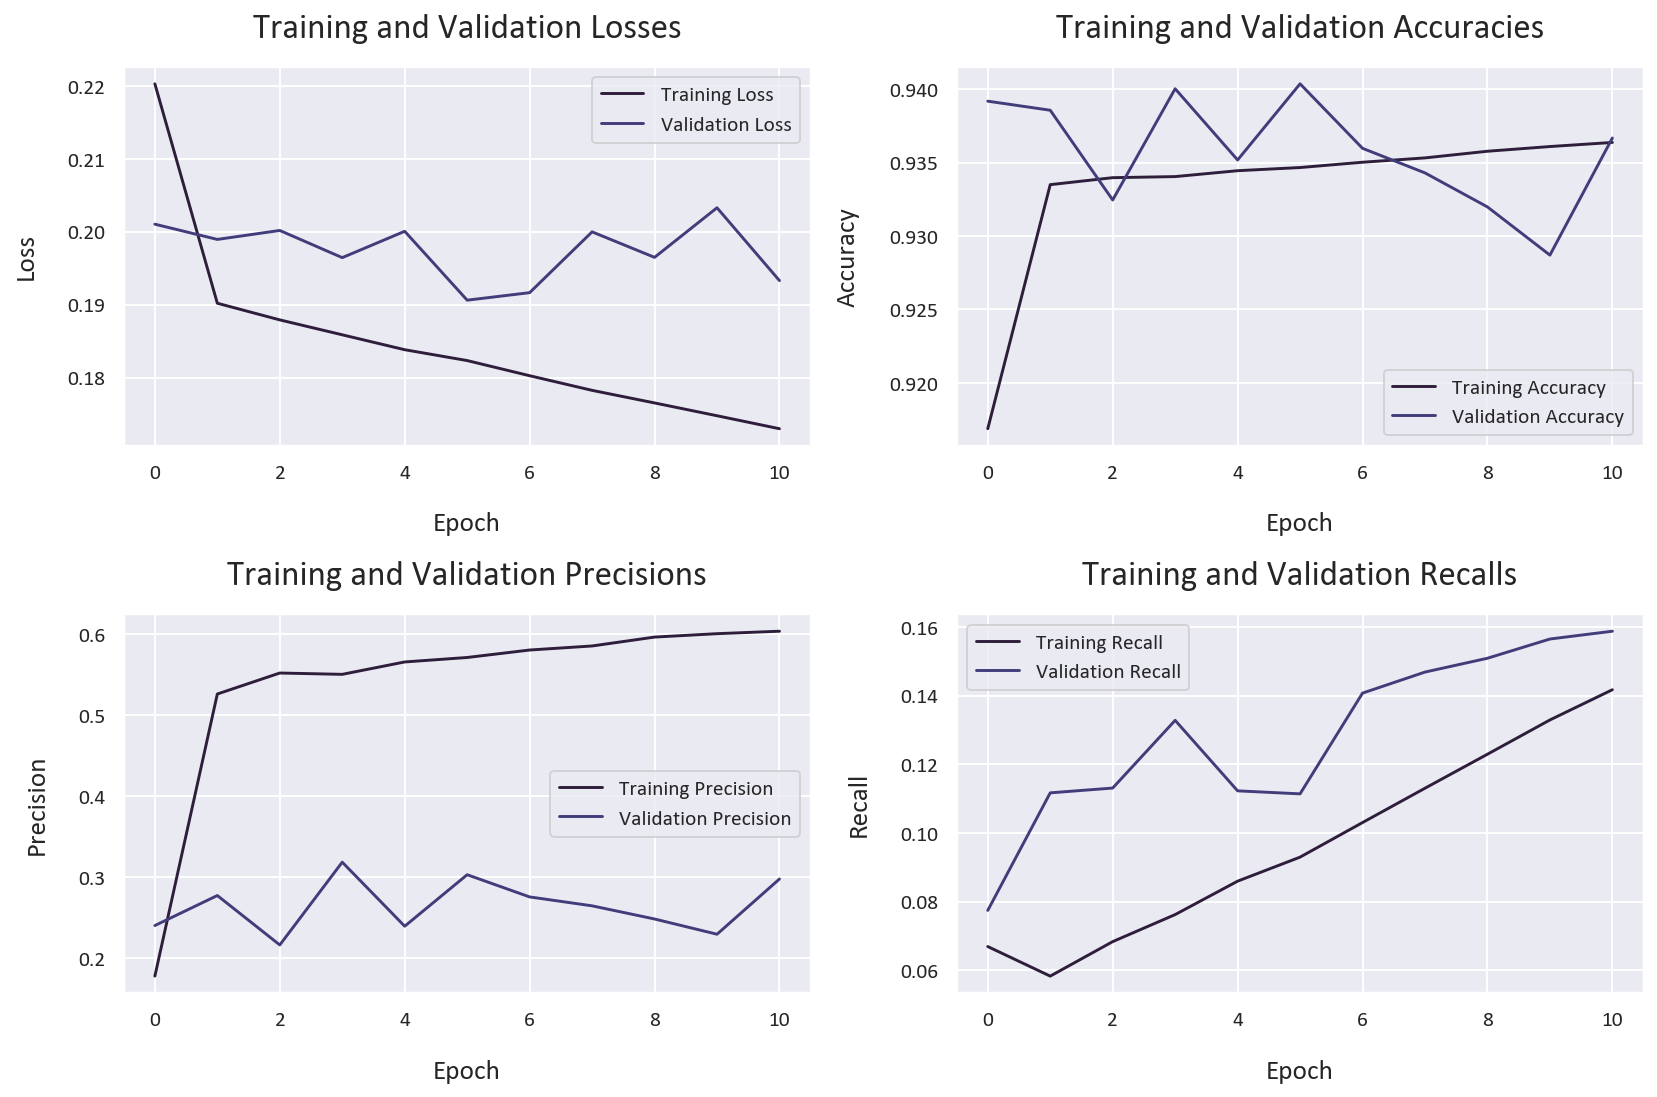

In [55]:
# Plot the training and validation metrics
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_cnn_2.history['loss'], label='Training Loss')
plt.plot(history_cnn_2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.subplot(2, 2, 2)
plt.plot(history_cnn_2.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history_cnn_2.history['val_binary_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.subplot(2, 2, 3)
plt.plot(history_cnn_2.history['precision'], label='Training Precision')
plt.plot(history_cnn_2.history['val_precision'], label='Validation Precision')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precisions')
plt.subplot(2, 2, 4)
plt.plot(history_cnn_2.history['recall'], label='Training Recall')
plt.plot(history_cnn_2.history['val_recall'], label='Validation Recall')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recalls')
plt.tight_layout()

In [47]:
# Load the best model
model_cnn_2 = tf.keras.models.load_model('models/model-binary_crossentropy.keras', custom_objects={'weighted_binary_crossentropy': create_weighted_binary_crossentropy(class_weights)})
# Compute the predictions
predictions_cnn_2 = model_cnn_2.predict(test_ds)

690/690 [==============================] - 12s 17ms/step


In [64]:
# Initialize dictionaries
fpr_dict_bc = {}
tpr_dict_bc = {}
auc_dict_bc = {}

# Compute the ROC curve and AUC score for each disease
for i, disease in enumerate(diseases):
    fpr, tpr, _ = roc_curve(test_df[disease], predictions_cnn_2[:, i])
    auc_score = auc(fpr, tpr)
    
    fpr_dict_bc[disease] = fpr
    tpr_dict_bc[disease] = tpr
    auc_dict_bc[disease] = auc_score

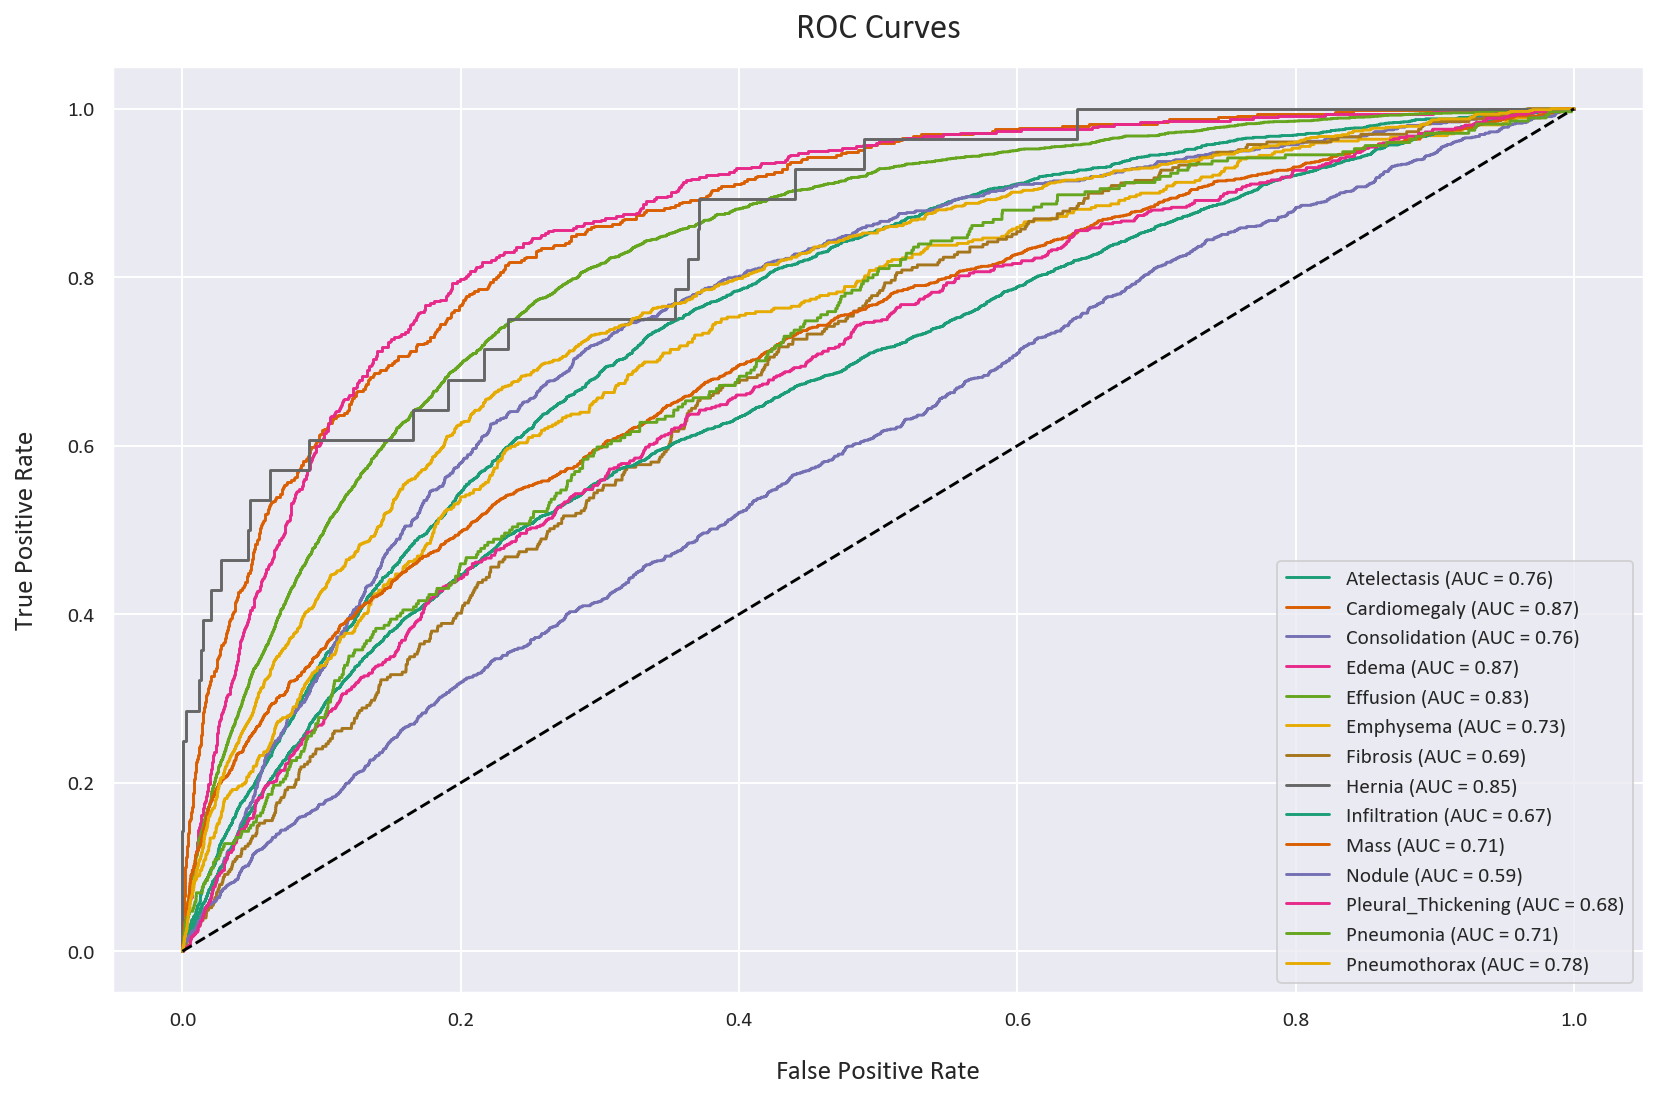

In [65]:
# Plot the ROC curves
plt.figure(figsize=(12, 8))
with sns.color_palette("Dark2"):
    for disease in diseases:
        plt.plot(fpr_dict_bc[disease], tpr_dict_bc[disease], label=f'{disease} (AUC = {auc_dict_bc[disease]:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()

In [66]:
# Compare the AUC scores
print('Weighted Binary Cross-Entropy AUC Scores:')
for disease in diseases:
    print(f'{disease}: {auc_dict_wbc[disease]:.2f}')
print('\nBinary Cross-Entropy AUC Scores:')
for disease in diseases:
    print(f'{disease}: {auc_dict_bc[disease]:.2f}')

Weighted Binary Cross-Entropy AUC Scores:
Atelectasis: 0.74
Cardiomegaly: 0.87
Consolidation: 0.76
Edema: 0.87
Effusion: 0.82
Emphysema: 0.72
Fibrosis: 0.70
Hernia: 0.86
Infiltration: 0.67
Mass: 0.70
Nodule: 0.59
Pleural_Thickening: 0.69
Pneumonia: 0.74
Pneumothorax: 0.77

Binary Cross-Entropy AUC Scores:
Atelectasis: 0.76
Cardiomegaly: 0.87
Consolidation: 0.76
Edema: 0.87
Effusion: 0.83
Emphysema: 0.73
Fibrosis: 0.69
Hernia: 0.85
Infiltration: 0.67
Mass: 0.71
Nodule: 0.59
Pleural_Thickening: 0.68
Pneumonia: 0.71
Pneumothorax: 0.78


In [69]:
# Print the average AUC scores for each model
print(f'Average AUC Score (Weighted Binary Cross-Entropy): {np.mean(list(auc_dict_wbc.values())):.2f}')
print(f'Average AUC Score (Binary Cross-Entropy): {np.mean(list(auc_dict_bc.values())):.2f}')

Average AUC Score (Weighted Binary Cross-Entropy): 0.75
Average AUC Score (Binary Cross-Entropy): 0.75


As we can see, the two models have almost the AUROC, this surely means that the two models have similar performance, right? Maybe even the binary cross-entropy loss model is better since it has way higher accuracy, right? Wrong. This is a common mistake that people make when evaluating models for medical datasets. The AUROC is a good metric to use for evaluating the performance of a model, but it can be deceiving. Let's compare the recall and precision of the two models.

In [67]:
# Compare the two classification reports
print('Weighted Binary Cross-Entropy:')
print(classification_report(test_df[diseases], predictions_cnn > 0.5, target_names=diseases))
print('\nBinary Cross-Entropy:')
print(classification_report(test_df[diseases], predictions_cnn_2 > 0.5, target_names=diseases))
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

Weighted Binary Cross-Entropy:
                    precision    recall  f1-score   support

       Atelectasis       0.16      0.84      0.27      2322
      Cardiomegaly       0.05      0.93      0.09       490
     Consolidation       0.05      0.96      0.10       957
             Edema       0.07      0.87      0.12       494
          Effusion       0.23      0.90      0.37      2869
         Emphysema       0.04      0.76      0.07       469
          Fibrosis       0.02      0.81      0.04       329
            Hernia       0.01      0.57      0.02        28
      Infiltration       0.22      0.77      0.34      3831
              Mass       0.06      0.97      0.12      1272
            Nodule       0.06      0.98      0.11      1273
Pleural_Thickening       0.04      0.82      0.08       615
         Pneumonia       0.02      0.94      0.03       274
      Pneumothorax       0.06      0.88      0.12       908

         micro avg       0.08      0.87      0.15     16131
       

As expected, the binary cross-entropy loss model has a higher precision but abyssmal recall. This means that the model will tend to classify most patients as healthy, even if they have a disease. The weighted binary cross-entropy loss model has a lower precision but a much higher recall. This means that the model will not miss a positive sample very often. This will prevent false negatives. Which model would you rather use in a medical setting? I would definitely use the weighted binary cross-entropy loss model.

Let's further confirm this by looking at the percentage of the positive and negative cases that were correctly classified by each model.

In [63]:
# What is the percentage of correctly identified positive cases for the weighted binary cross-entropy model?
# Initialize a dictionary
correctly_identified_p = {}

# Loop over the diseases
for disease in diseases:
    # Get the indices of the positive cases
    indices = test_df[test_df[disease] == 1].index
    # Get the predictions for the positive cases
    disease_predictions = predictions_cnn[indices, diseases.index(disease)]
    # Get the indices of the correctly identified positive cases
    correctly_identified_p[disease] = np.where(disease_predictions > 0.5)[0]

# Print the percentage of correctly identified positive cases for each disease 
print('Weighted Binary Cross-Entropy correctly identified positive cases:')
for disease in diseases:
    print(f'{disease}: {len(correctly_identified_p[disease]) / len(test_df[test_df[disease] == 1]) * 100:.2f}%')

# Print the total percentage of correctly identified positive cases for all diseases
# Initialize counters
total_correctly_identified_p = 0
total_positive_cases = 0

# Loop over the diseases
for disease in diseases:
    # Add the number of correctly identified positive cases and the total number of positive cases for this disease
    total_correctly_identified_p += len(correctly_identified_p[disease])
    total_positive_cases += len(test_df[test_df[disease] == 1])

# Calculate and print the total percentage of correctly identified positive cases
total_percentage_p_w = total_correctly_identified_p / total_positive_cases * 100
print(f'Total percentage of correctly identified positive cases for all diseases: {total_percentage_p_w:.2f}%')

# What is the percentage of correctly identified negative cases for the weighted binary cross-entropy model?
# Initialize a dictionary
correctly_identified_n = {}

# Loop over the diseases

for disease in diseases:
    # Get the indices of the negative cases
    indices = test_df[test_df[disease] == 0].index
    # Get the predictions for the negative cases
    disease_predictions = predictions_cnn[indices, diseases.index(disease)]
    # Get the indices of the correctly identified negative cases
    correctly_identified_n[disease] = np.where(disease_predictions < 0.5)[0]

# Print the percentage of correctly identified negative cases for each disease
print('\nWeighted Binary Cross-Entropy correctly identified negative cases:')
for disease in diseases:
    print(f'{disease}: {len(correctly_identified_n[disease]) / len(test_df[test_df[disease] == 0]) * 100:.2f}%')

# Print the total percentage of correctly identified negative cases
# Initialize counters
total_correctly_identified_n = 0
total_negative_cases = 0

# Loop over the diseases
for disease in diseases:
    # Add the number of correctly identified negative cases and the total number of negative cases for this disease
    total_correctly_identified_n += len(correctly_identified_n[disease])
    total_negative_cases += len(test_df[test_df[disease] == 0])

# Calculate and print the total percentage of correctly identified negative cases
total_percentage_n_w = total_correctly_identified_n / total_negative_cases * 100
print(f'Total percentage of correctly identified negative cases for all diseases: {total_percentage_n_w:.2f}%')

Weighted Binary Cross-Entropy correctly identified positive cases:
Atelectasis: 84.50%
Cardiomegaly: 93.47%
Consolidation: 96.13%
Edema: 87.45%
Effusion: 90.14%
Emphysema: 76.33%
Fibrosis: 80.85%
Hernia: 57.14%
Infiltration: 76.82%
Mass: 96.70%
Nodule: 97.88%
Pleural_Thickening: 81.63%
Pneumonia: 94.16%
Pneumothorax: 87.67%
Total percentage of correctly identified positive cases for all diseases: 86.62%

Weighted Binary Cross-Entropy correctly identified negative cases:
Atelectasis: 49.30%
Cardiomegaly: 57.52%
Consolidation: 20.57%
Edema: 71.27%
Effusion: 54.97%
Emphysema: 55.34%
Fibrosis: 47.19%
Hernia: 93.03%
Infiltration: 42.50%
Mass: 11.38%
Nodule: 6.53%
Pleural_Thickening: 43.63%
Pneumonia: 27.32%
Pneumothorax: 44.38%
Total percentage of correctly identified negative cases for all diseases: 44.84%


In [64]:
# What is the percentage of correctly identified positive cases for the binary cross-entropy model?
# Initialize a dictionary
correctly_identified_p = {}

# Loop over the diseases
for disease in diseases:
    # Get the indices of the positive cases
    indices = test_df[test_df[disease] == 1].index
    # Get the predictions for the positive cases
    disease_predictions = predictions_cnn_2[indices, diseases.index(disease)]
    # Get the indices of the correctly identified positive cases
    correctly_identified_p[disease] = np.where(disease_predictions > 0.5)[0]

# Print the percentage of correctly identified positive cases for each disease
print('Binary Cross-Entropy correctly identified positive cases:')
for disease in diseases:
    print(f'{disease}: {len(correctly_identified_p[disease]) / len(test_df[test_df[disease] == 1]) * 100:.2f}%')

# Print the total percentage of correctly identified positive cases
# Initialize counters
total_correctly_identified_p = 0
total_positive_cases = 0

# Loop over the diseases
for disease in diseases:
    # Add the number of correctly identified positive cases and the total number of positive cases for this disease
    total_correctly_identified_p += len(correctly_identified_p[disease])
    total_positive_cases += len(test_df[test_df[disease] == 1])

# Calculate and print the total percentage of correctly identified positive cases
total_percentage_p = total_correctly_identified_p / total_positive_cases * 100
print(f'Total percentage of correctly identified positive cases for all diseases: {total_percentage_p:.2f}%')

# What is the percentage of correctly identified negative cases for the binary cross-entropy model?
# Initialize a dictionary
correctly_identified_n = {}

# Loop over the diseases
for disease in diseases:
    # Get the indices of the negative cases
    indices = test_df[test_df[disease] == 0].index
    # Get the predictions for the negative cases
    disease_predictions = predictions_cnn_2[indices, diseases.index(disease)]
    # Get the indices of the correctly identified negative cases
    correctly_identified_n[disease] = np.where(disease_predictions < 0.5)[0]

# Print the percentage of correctly identified negative cases for each disease
print('\nBinary Cross-Entropy correctly identified negative cases:')
for disease in diseases:
    print(f'{disease}: {len(correctly_identified_n[disease]) / len(test_df[test_df[disease] == 0]) * 100:.2f}%')

# Print the total percentage of correctly identified negative cases
# Initialize counters
total_correctly_identified_n = 0
total_negative_cases = 0

# Loop over the diseases
for disease in diseases:
    # Add the number of correctly identified negative cases and the total number of negative cases for this disease
    total_correctly_identified_n += len(correctly_identified_n[disease])
    total_negative_cases += len(test_df[test_df[disease] == 0])

# Calculate and print the total percentage of correctly identified negative cases
total_percentage_n = total_correctly_identified_n / total_negative_cases * 100
print(f'Total percentage of correctly identified negative cases for all diseases: {total_percentage_n:.2f}%')


Binary Cross-Entropy correctly identified positive cases:
Atelectasis: 0.90%
Cardiomegaly: 28.37%
Consolidation: 6.27%
Edema: 3.64%
Effusion: 18.23%
Emphysema: 5.33%
Fibrosis: 0.00%
Hernia: 10.71%
Infiltration: 8.54%
Mass: 8.41%
Nodule: 12.33%
Pleural_Thickening: 0.00%
Pneumonia: 0.00%
Pneumothorax: 31.17%
Total percentage of correctly identified positive cases for all diseases: 10.31%

Binary Cross-Entropy correctly identified negative cases:
Atelectasis: 99.80%
Cardiomegaly: 98.49%
Consolidation: 97.94%
Edema: 99.78%
Effusion: 97.93%
Emphysema: 99.62%
Fibrosis: 100.00%
Hernia: 100.00%
Infiltration: 97.67%
Mass: 99.41%
Nodule: 94.17%
Pleural_Thickening: 99.99%
Pneumonia: 100.00%
Pneumothorax: 94.37%
Total percentage of correctly identified negative cases for all diseases: 98.54%


In [65]:
# Compare the total percentages of correctly identified positive and negative cases for the two models
print('Weighted Binary Cross-Entropy:')
print(f'Total percentage of correctly identified positive cases for all diseases: {total_percentage_p_w:.2f}%')
print(f'Total percentage of correctly identified negative cases for all diseases: {total_percentage_n_w:.2f}%')
print('\nBinary Cross-Entropy:')
print(f'Total percentage of correctly identified positive cases for all diseases: {total_percentage_p:.2f}%')
print(f'Total percentage of correctly identified negative cases for all diseases: {total_percentage_n:.2f}%')

Weighted Binary Cross-Entropy:
Total percentage of correctly identified positive cases for all diseases: 86.62%
Total percentage of correctly identified negative cases for all diseases: 44.84%

Binary Cross-Entropy:
Total percentage of correctly identified positive cases for all diseases: 10.31%
Total percentage of correctly identified negative cases for all diseases: 98.54%


As we suspected earlier, the binary cross-entropy loss model has a high accuracy because it classifies most cases as negative. This is why it has a high precision but a low recall. This lead to it identifying 98.54% of the negative cases correctly but only 10.31% of the positive cases correctly. This is extremely dangerous.

The weighted binary cross-entropy loss model can distinguish between the positive and negative cases much better. This is why it has a lower accuracy but a higher recall. This lead to it identifying 86.62 of positive cases correctly and 44.84% of the negative cases correctly. 

This is much, much better than the binary cross-entropy loss model. Yes, 55.16% of healthy patients were misdiagnosed, but patients usually go for further testing to confirm the diagnosis. This is contrary to patients with a disease, where if they were told they do not have a disease, they may not go for further testing until the symptoms get worse. This is usually when it is too late and can make recovery much harder. This is why we want to minimize the number of false negatives, even if it means increasing the number of false positives.